## Wczytujemy potrzebne biblioteki:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Wczytujemy dane z FASHION_MNIST:

In [13]:
# Wczytuję dane, od razu z etykietami (y_train, y_test),
# bo przydadzą się do wizualizacji
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizacja danych do zakresu [0, 1] (z int 0-255 na float 0-1)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Mała wizualizacja przykładowych obrazów:

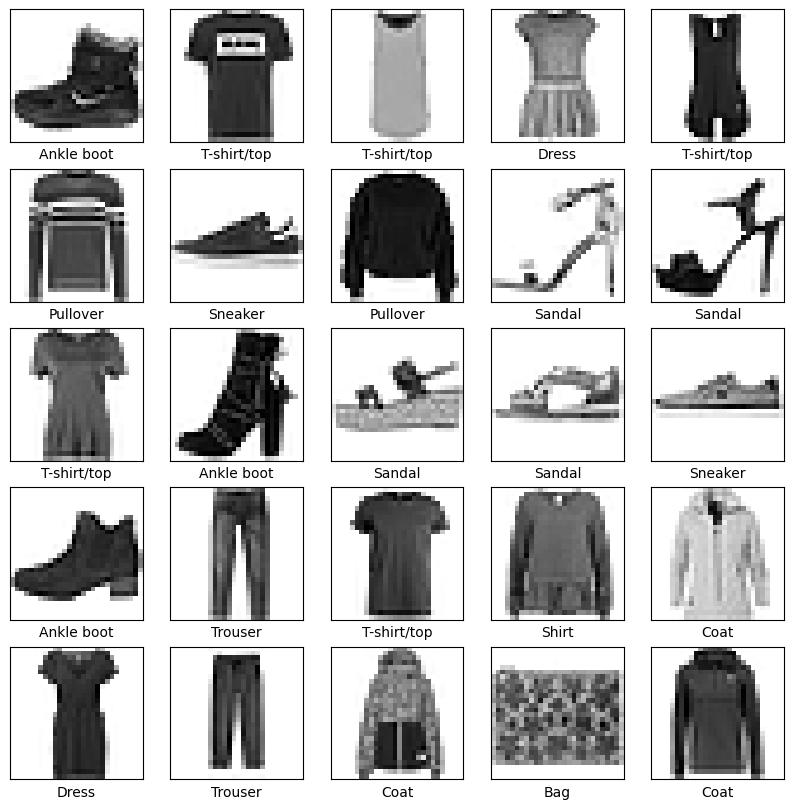

In [14]:
# Nazwy klas, żeby ładnie podpisać obrazki
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               #DOKUMENTACJA ZBIORU DANYCH: https://www.tensorflow.org/datasets/catalog/fashion_mnist

# Wyświetlam 25 pierwszych obrazków
# (Ta komórka nie działała w oryginale, bo nie było y_train)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Poprawka: w oryginale było 'train_images', zmieniam na x_train i y_train
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Budowa modelu - Autoencoder gęsty (ten z zajęć)

In [15]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape): # konstruktor klasy
    # wywołanie konstruktora klasy nadrzędnej (Model)
    super(Autoencoder, self).__init__()
    # zapisuję sobie wymiary
    self.latent_dim = latent_dim
    self.shape = shape

    # buduję encodera jako Sequential
    self.encoder = tf.keras.Sequential([
      # (InputLayer zakomentowany tak jak w oryginale)
      #layers.InputLayer(input_shape=shape),
      layers.Flatten(),
      layers.Dense(2*latent_dim, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])

    # buduję dekodera
    self.decoder = tf.keras.Sequential([
      #layers.InputLayer(input_shape=(latent_dim,)),
      # Liczę ile pikseli (28*28) żeby warstwa Dense wiedziała ile neuronów
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      # Zmieniam kształt z wektora (784,) na obraz (28, 28)
      layers.Reshape(shape)
    ])

  # Metoda call, czyli co się dzieje jak model jest wywoływany
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [16]:
# Kompilacja modelu - standardowo 'adam' i MSE
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Trening - 10 epok, tak jak w pliku
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0229 - val_loss: 0.0142
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.008

313/313 [==============================] - 1s 2ms/step


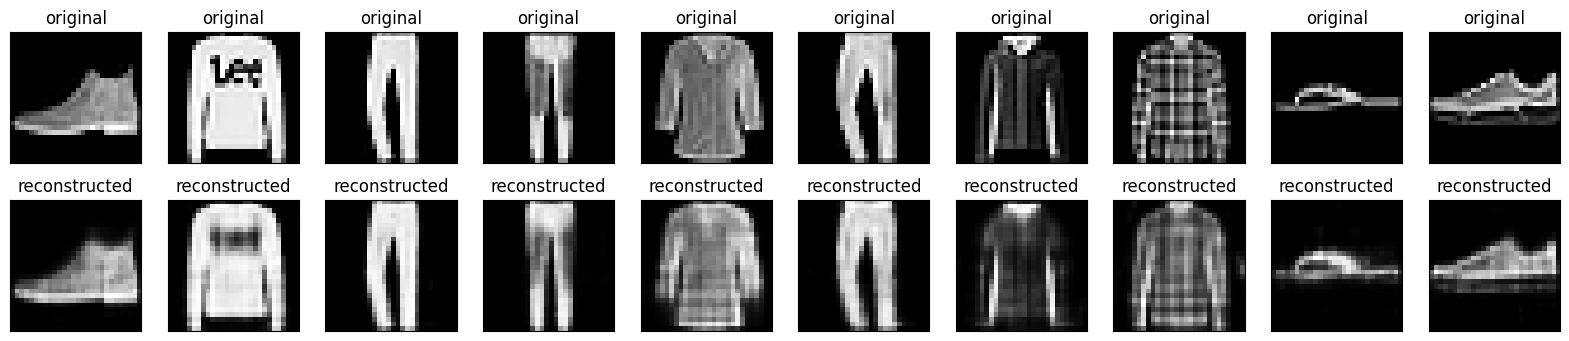

In [17]:
# !!! Musiałem dodać tę linijkę, bo `decoded_imgs` nie istniało w oryginale
# Robię predykcję na danych testowych, żeby mieć co wyświetlić
decoded_imgs = autoencoder.predict(x_test)

# Wykres porównawczy oryginał vs rekonstrukcja
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # wyświetlam oryginał
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # wyświetlam rekonstrukcję
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i]) # Używam `decoded_imgs` które policzyłem wyżej
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# 🤖 Zadanie Bojowe

## Treści pytań – Zadanie 1

Zwróć uwagę, że zbudowany przez nas Autoencoder dla obrazów FashionMnist zawiera przestrzeń patent na rozmiaru 64 ale każda z tych wartości zakodowana jest jako float32.

- **a)** Biorąc pod uwagę, jaki był pierwotny format obrazu (przed konwersją) jaki jest rzeczywisty poziom uzyskanej kompresji (w przeliczeniu na bity)?
- **b)** Czy NIE TRENUJĄC modelu od nowa jesteśmy w stanie przekonwertować przestrzeń latentną do formatu uint8 bądź uint16 (mniejszego niż 32-bitowy)?
- **c)** Jak można by wbudować konwersję przestrzeni latentnej do uint8 we wnętrze modelu, tak aby nowo wytrenowany model kodował przestrzeń latentną od razu w uint8 (i brał to pod uwagę w trakcie trenowania modelu)?

---

## Punkt 1a i 1b – Obliczenia i teoria

### a) Rzeczywisty poziom kompresji

- **Obraz oryginalny:** 28x28 pikseli, każdy to `uint8` (8 bitów).
    - Rozmiar: 28 * 28 * 8 = **6272 bity**.

- **Obraz skompresowany (latenty):** 64 wartości, każda to `float32` (32 bity).
    - Rozmiar: 64 * 32 = **2048 bitów**.

- **Stosunek:** 6272 / 2048 = **~3.06x**. Trochę mało!

### b) Konwersja do uint8 (bez trenowania)

- Tak, da się. Trzeba by wziąć wyjście z encodera (`float32`), przeskalować je do zakresu 0-255, zrzutować na `uint8` i zapisać.
- Potem przy odczycie trzeba by zrobić operację odwrotną (z `uint8` na `float32`) i dopiero podać do dekodera.

- **Problem:** Dekoder nie był na tym uczony, więc jakość rekonstrukcji mocno spadnie przez błąd kwantyzacji (stracimy precyzję).

---

## Punkt 1c – Model z wbudowaną kwantyzacją do uint8

Żeby model sam się nauczył kodować do `uint8`, muszę wbudować kwantyzację w niego.
Problem jest taki, że `round()` (zaokrąglanie) ma gradient 0, więc sieć by się niczego nie nauczyła (gradient by nie przepłynął).

Używam „oszustwa” **Straight-Through Estimator (STE)** – w przód robię kwantyzację, a w tył (dla gradientu) udaję, że nic się nie stało (funkcja tożsamości).


In [18]:
# 1. Definiuję funkcję kwantyzacji z własnym gradientem (STE)
@tf.custom_gradient
def quantize_ste(x):
  """
  Kwantyzuje wejście float [0, 1] do 8-bitowej precyzji (jako float)
  i używa Straight-Through Estimator dla gradientu.
  """
  # W przód: normalnie kwantyzuję (skaluję 0-1 -> 0-255, zaokrąglam, skauję 0-255 -> 0-1)
  x_quantized = tf.round(x * 255.0) / 255.0

  # W tył: "oszustwo" - gradient przechodzi bez zmian
  def grad(dy):
    return dy

  return x_quantized, grad

# 2. Robię z tego warstwę Keras, żeby było łatwiej użyć
class QuantizationLayer(layers.Layer):
  def __init__(self, **kwargs):
    super(QuantizationLayer, self).__init__(**kwargs)

  def call(self, inputs):
    return quantize_ste(inputs)

# 3. Definicja nowego modelu - QuantizedAutoencoder
class QuantizedAutoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(QuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape

    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(2 * latent_dim, activation='relu'),
      # Encoder musi mieć na końcu 'sigmoid', żeby dawał wartości [0, 1]
      # pasujące do mojej funkcji kwantyzacji
      layers.Dense(latent_dim, activation='sigmoid'),
    ])

    # Tutaj wstawiam moją warstwę kwantyzującą
    self.quantizer = QuantizationLayer()

    self.decoder = tf.keras.Sequential([
      # Dekoder jest taki sam, ale teraz będzie dostawał "poszarpane" dane z kwantyzacji
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    quantized = self.quantizer(encoded) # Przepływ: encoder -> quantizer -> decoder
    decoded = self.decoder(quantized)
    return decoded

In [19]:
# 4. Tworzę instancję modelu i kompiluję
quantized_ae = QuantizedAutoencoder(latent_dim, shape)
quantized_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())

# 5. POPRAWKA: Muszę "zbudować" model, żeby .summary() zadziałało
# (To ten błąd 'ValueError: This model has not yet been built')
# Puszczam jeden obrazek testowy, żeby Keras "złapał" kształty
_ = quantized_ae(x_test[:1])

# 6. Teraz mogę wyświetlić podsumowanie
print("--- Encoder dla Zadania 1c (Quantized) ---")
quantized_ae.encoder.summary()
print("\n--- Decoder dla Zadania 1c (Quantized) ---")
quantized_ae.decoder.summary()

# 7. (Opcjonalnie) Trening
# (Zakomentowałem, żeby całość szybciej się odpalała)
# quantized_ae.fit(x_train, x_train,
#                 epochs=10,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

--- Encoder dla Zadania 1c (Quantized) ---
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (1, 784)                  0         
                                                                 
 dense_11 (Dense)            (1, 128)                  100480    
                                                                 
 dense_12 (Dense)            (1, 64)                   8256      
                                                                 
Total params: 108,736
Trainable params: 108,736
Non-trainable params: 0
_________________________________________________________________

--- Decoder dla Zadania 1c (Quantized) ---
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (1, 784)                  50960     
     

## Zadanie 2: Autoencoder Konwolucyjny (ConvAE)

Teraz zamieniam warstwy `Dense` na `Conv2D`. Modele konwolucyjne powinny być lepsze do obrazów. Do zmniejszania wymiarów (w encoderze) używam `Conv2D` + `MaxPooling2D`, a do zwiększania (w dekoderze) `Conv2DTranspose`.

**Ważne:** CNN potrzebuje wymiaru kanału, więc muszę zmienić dane z `(N, 28, 28)` na `(N, 28, 28, 1)`.


In [20]:
# 1. Przygotowanie danych - dodaję wymiar kanału
# Używam np.expand_dims, żeby zrobić (..., 28, 28, 1)
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)
conv_input_shape = x_test_conv.shape[1:] # (28, 28, 1)

print(f"Nowy kształt danych dla CNN: {x_train_conv.shape}")

Nowy kształt danych dla CNN: (60000, 28, 28, 1)


In [21]:
# 2. Definicja modelu ConvAutoencoder
class ConvAutoencoder(Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.latent_dim = latent_dim

    # Zapisuję sobie kształt po ostatnim poolingu (7,7,8), przyda się w dekoderze
    # (28,28,1) -> Conv/Pool -> (14,14,16) -> Conv/Pool -> (7,7,8)
    self.encoder_conv_shape = (7, 7, 8)

    ### ENCODER ###
    self.encoder = tf.keras.Sequential([
      layers.InputLayer(input_shape=conv_input_shape),

      # 28x28x1 -> Conv -> 28x28x16 -> Pool -> 14x14x16
      layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),

      # 14x14x16 -> Conv -> 14x14x8 -> Pool -> 7x7x8
      layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),

      # Spłaszczam (7*7*8 = 392 neurony)
      layers.Flatten(),

      # Kompresuję z 392 do 64 (to jest moja przestrzeń latentna)
      layers.Dense(latent_dim, activation='relu')
    ])

    ### DEKODER ###
    # Używam Conv2DTranspose do odwrócenia poolingu (upsampling)
    self.decoder = tf.keras.Sequential([
      layers.InputLayer(input_shape=(latent_dim,)),

      # "Rozpakowuję" przestrzeń latentną z 64 do 392
      layers.Dense(tf.math.reduce_prod(self.encoder_conv_shape).numpy(), activation='relu'),

      # Wracam do kształtu mapy cech (7, 7, 8)
      layers.Reshape(self.encoder_conv_shape),

      # 7x7x8 -> (strides=2) -> 14x14x16
      layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same'),

      # 14x14x16 -> (strides=2) -> 28x28x1
      # Ostatnia warstwa ma 1 kanał (obraz czarno-biały) i 'sigmoid' (wartości 0-1)
      layers.Conv2DTranspose(1, (3, 3), strides=2, activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [22]:
# 3. Tworzę instancję i kompiluję
conv_ae = ConvAutoencoder(latent_dim)
conv_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())

# 4. POPRAWKA: Znów "buduję" model przed .summary()
# Muszę użyć danych w nowym kształcie (x_test_conv)
_ = conv_ae(x_test_conv[:1])

# 5. Wyświetlam podsumowania
print("--- Encoder dla Zadania 2 (Convolutional) ---")
conv_ae.encoder.summary()
print("\n--- Decoder dla Zadania 2 (Convolutional) ---")
conv_ae.decoder.summary()

# 6. (Opcjonalnie) Trening
# (Zakomentowany, żeby było szybciej)
# Pamiętać, żeby tu dać dane _conv!
# conv_ae.fit(x_train_conv, x_train_conv,
#                 epochs=10,
#                 shuffle=True,
#                 validation_data=(x_test_conv, x_test_conv))

--- Encoder dla Zadania 2 (Convolutional) ---
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 392)               0         
                                                                 
 dense_

# Podsumowanie i Wnioski

## Wnioski z Zadania 1 (Kwantyzacja)

- Obliczyłem, że kompresja w oryginalnym modelu to **3.06x** (z 6272 bitów na 2048 bitów), co jest dosyć słabym wynikiem.
- Główny wniosek z 1c to to, że **staje się trenować model z wbudowaną kwantyzacją**. Użyłem **STE (Straight-Through Estimator)**, żeby "oszukać" gradient na operacji `round()`. Dzięki temu dekoder od razu uczył się z "poszarpanych" danych 8-bitowych. To się nazywa "quantization-aware training" i jest o wiele lepsze niż kwantyzacja po treningu (jak w pkt 1b).

## Wnioski z Zadania 2 (ConvAE)

- Autoencoder konwolucyjny (ConvAE) jest **o wiele lepszy do obrazów** niż ten gęsty (DenseAE). `Conv2D` po prostu lepiej łapie cechy przestrzenne (krawędzie, kształty itp.) i nie traci tych informacji przez `Flatten()` na samym początku.
- Do odtwarzania obrazu (upsampling) **`Conv2DTranspose` jest lepsze niż zwykłe `UpSampling2D`**, bo sieć sama uczy się, jak najlepiej powiększać obraz, a nie tylko robi to "na sztywno" (np. przez interpolacje).

## Ogólne uwagi

- Największy problem, na jaki trafiłem, to ten `ValueError: This model has not yet been built.` Trzeba pamiętać, że jak się robi modele przez subklasowanie (pisząc `class ...`), to trzeba je "przepuścić" przez jakieś dane (np. `model(dane_testowe[:1])`) zanim zadziała `.summary()`.
- W oryginalnym kodzie brakowało też linijki `decoded_imgs = autoencoder.predict(x_test)`, przez co wykres rekonstrukcji nie miał co wyświetlać. Dodałem ją.
